In [1]:
import librosa
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook

# Brute force linear regression

The idea here is to predict the note frequency of an mp3 file containing a single note using linear regression. The features will be the amplitude values of n samples (info from the time domain). Although this is technically a classification problem, it's interesting to try out this approach since the frequency is a continuous variable.

## Data preprocessing (single file)

First we remove the samples before the note begins.

In [2]:
y, sr = librosa.load("../Audio_processing_tests/mp3 Notes/a3.mp3", mono=False)

In [3]:
y = librosa.core.to_mono(y)
# We'll work with mono here

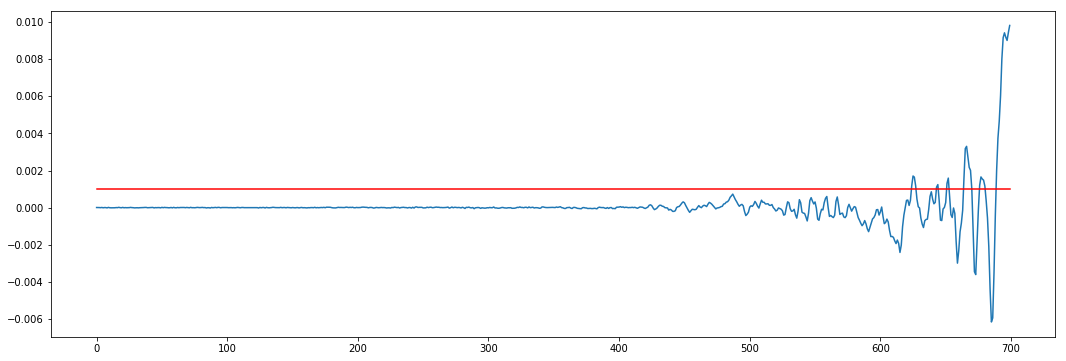

In [4]:
plt.figure(figsize=(18,6))
plt.plot(y[:700])
plt.plot([0.001]*700, 'r')

In [5]:
y = y[np.argwhere(y >= 0.001)[0][0]:]

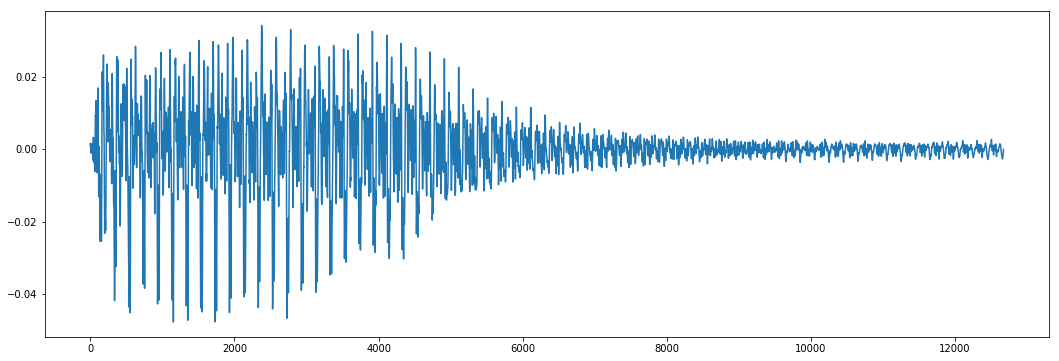

In [6]:
plt.figure(figsize=(18,6))
plt.plot(y)

Next we resample the waveform to reduce the number of future features

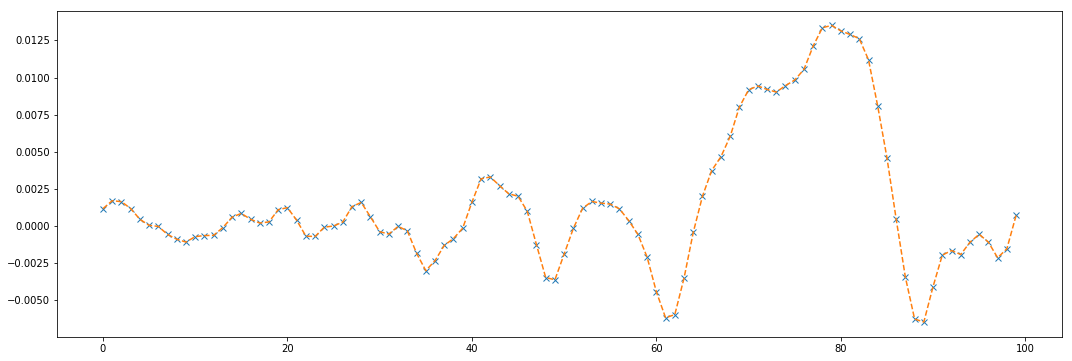

In [7]:
plt.figure(figsize=(18,6))
plt.plot(y[:100], 'x')
plt.plot(y[:100], '--')

In [8]:
y = librosa.resample(y, sr, 8000)

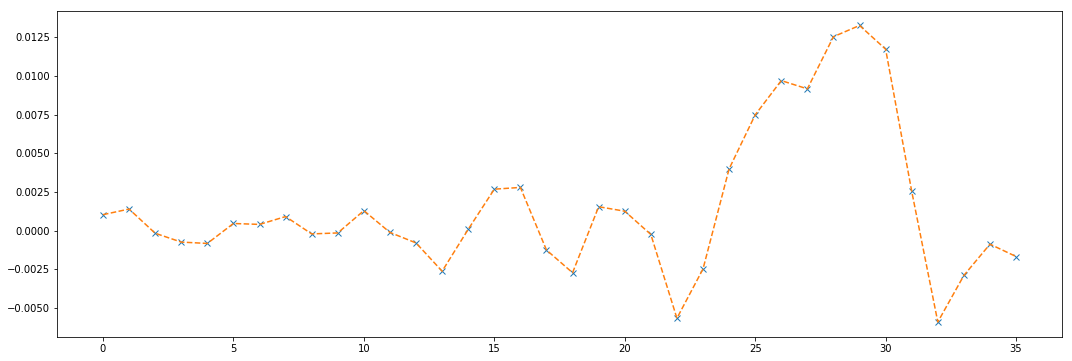

In [9]:
plt.figure(figsize=(18,6))
plt.plot(y[:round(100*8000/sr)], 'x')
plt.plot(y[:round(100*8000/sr)], '--')

There already seems to be a recognizable pattern at around 100 samples

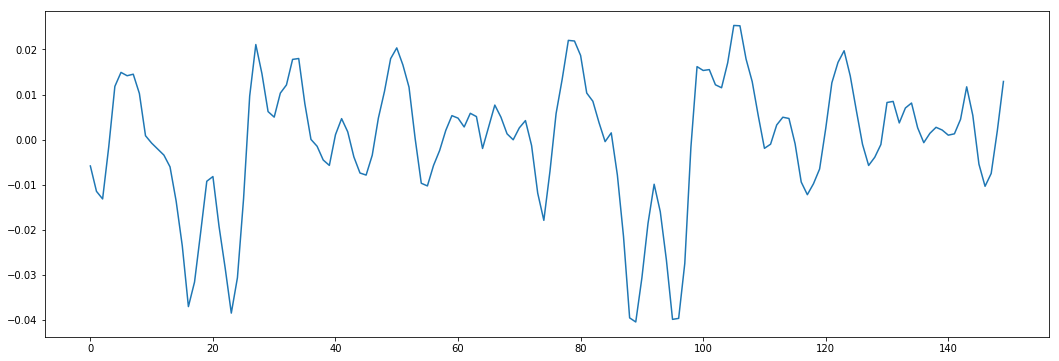

In [10]:
plt.figure(figsize=(18,6))
plt.plot(y[250:400])

Now we can split the waveform into chunks of 100 samples to use them as separate examples

In [2]:
note_table = pd.read_csv("../Utilities/Note_table.tsv", header=0, sep="\t")
note_table.head()

,Note,Freq
0,C0,16.351598
1,C#0,17.323914
2,D0,18.354048
3,D#0,19.445436
4,E0,20.601722


In [12]:
note_table[note_table["Note"] == "A3"]["Freq"]

45    220.0
Name: Freq, dtype: float64

In [13]:
data = pd.DataFrame(columns=["x{}".format(i) for i in range(100)])

In [14]:
for t in range(0, len(y)-100, 100):
    y_chunk = y[t:(t+100)]
    data = data.append(pd.DataFrame({"x{}".format(i): [y_chunk[i]] for i in range(100)}))

In [15]:
data = data.reset_index().drop("index", axis=1)
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0.001025,0.001389,-0.000176,-0.000749,-0.000836,0.000455,0.000395,0.000902,-0.000220,-0.000157,...,0.018775,0.016326,0.013896,0.010763,0.011352,0.010369,0.006090,-0.001213,-0.002487,0.001588
1,0.001220,0.004228,0.003287,-0.001491,0.002415,0.005526,-0.001426,-0.009821,-0.002149,0.015404,...,-0.011945,-0.018910,-0.025112,-0.030585,-0.041974,-0.041180,-0.027273,-0.009221,-0.012685,-0.025940
2,-0.038639,-0.044338,-0.024061,-0.001734,0.019513,0.023870,0.016353,0.009345,0.008039,0.014047,...,0.001107,0.004665,0.001738,-0.003810,-0.007387,-0.007844,-0.003441,0.004792,0.010734,0.017967
3,0.020348,0.016576,0.011641,0.000260,-0.009655,-0.010248,-0.005714,-0.002381,0.002067,0.005329,...,0.001002,0.001302,0.004516,0.011719,0.005384,-0.005421,-0.010332,-0.007485,0.001982,0.012908
4,0.026487,0.024156,0.019214,0.013767,0.007092,0.000885,-0.003320,-0.000217,-0.007632,-0.019659,...,-0.047990,-0.042122,-0.027363,-0.007935,0.005005,0.007823,0.001965,0.005932,0.015841,0.019599


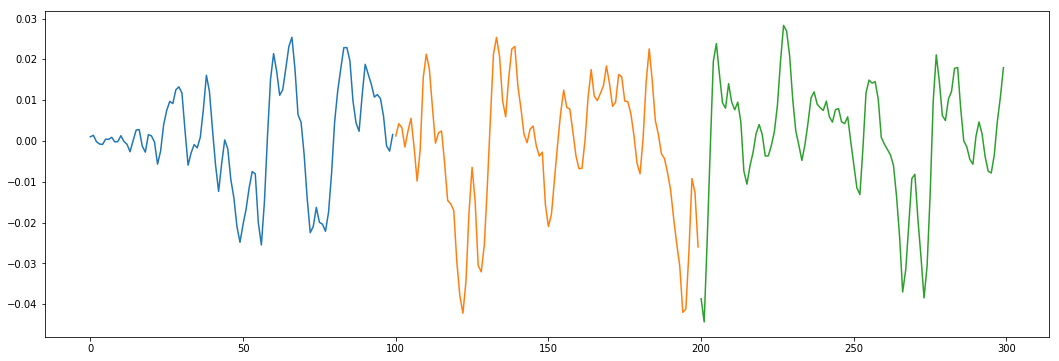

In [16]:
plt.figure(figsize=(18,6))
row0 = data.iloc[0]
row0.index = np.arange(100)
plt.plot(row0)
row1 = data.iloc[1]
row1.index = np.arange(100, 200)
plt.plot(row1)
row2 = data.iloc[2]
row2.index = np.arange(200, 300)
plt.plot(row2)

In [17]:
data["Freq"] = float(note_table[note_table["Note"] == "A3"]["Freq"])

In [18]:
data["Freq"].head()

0    220.0
1    220.0
2    220.0
3    220.0
4    220.0
Name: Freq, dtype: float64

## Data preprocessing (multiple files)

Now we can apply this to many files.

In [19]:
def file_to_data(file, rs, k, note_table):
    """
    Resample mp3 file to frequency rs, divide it into chunks of k samples and convert it
    to a dataframe
    """
    y, sr = librosa.load(file, mono=False)
    y = librosa.core.to_mono(y)
    y = y[np.argwhere(y >= 0.001)[0][0]:]
    y = librosa.resample(y, sr, rs)
    df = pd.DataFrame(columns=["x{}".format(i) for i in range(k)])
    
    for t in range(0, len(y)-k, k):
        y_chunk = y[t:(t+k)]
        df = df.append(pd.DataFrame({"x{}".format(i): [y_chunk[i]] for i in range(k)}))
        
    note_name = file.split('/')[-1].strip("mp3").strip(".").upper().replace("-", "#")
    df["Freq"] = float(note_table[note_table["Note"] == note_name]["Freq"])
    
    return df

Testing the function...

In [20]:
test = file_to_data("../Audio_processing_tests/mp3 Notes/a-3.mp3", 8000, 50, note_table)
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,Freq
0,0.000993,0.000338,0.000003,-0.000528,-0.000485,0.000146,0.000654,-0.000327,0.000165,0.002672,...,0.000060,-0.000659,-0.008528,-0.013385,-0.020310,-0.024101,-0.017991,-0.012810,-0.006837,233.081881
0,-0.003216,-0.010109,-0.023881,-0.023509,-0.012113,0.006211,0.019842,0.015610,0.009808,0.008467,...,-0.000434,-0.004019,0.000968,0.000344,0.003409,0.001183,-0.002116,0.003612,0.002653,233.081881
0,-0.005012,-0.007586,0.006615,0.019033,0.018834,0.013232,0.002450,0.002638,0.004233,-0.004110,...,-0.019637,-0.018077,-0.010877,-0.000433,0.007510,0.011413,0.007255,0.007317,0.000906,233.081881
0,-0.004454,-0.006503,-0.003838,0.004022,0.017083,0.016633,0.010503,0.011855,0.010800,0.016877,...,-0.007764,0.016037,0.026283,0.017614,0.010921,0.009173,0.013912,0.010374,0.009430,233.081881
0,0.010826,0.002778,-0.008269,-0.007846,-0.003056,0.001883,0.004993,0.001366,-0.005609,-0.006188,...,0.015234,0.012832,0.011670,0.001714,0.000231,0.000135,-0.002761,-0.005881,-0.014175,233.081881


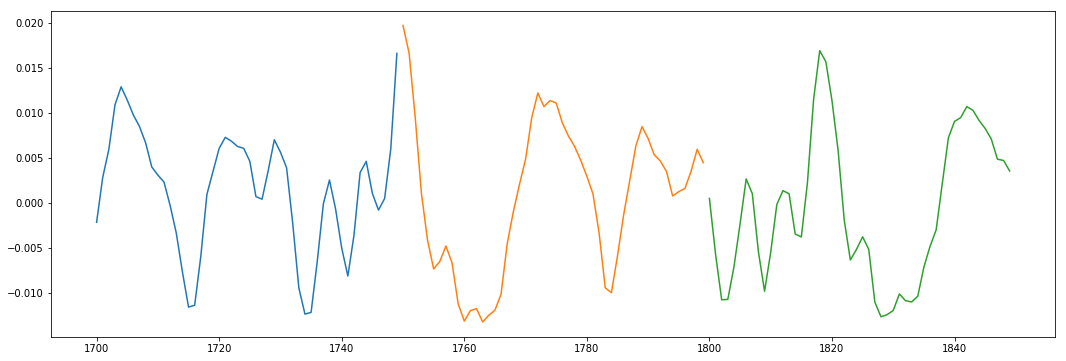

In [21]:
plt.figure(figsize=(18,6))
test = test.drop("Freq", axis=1)
row34 = test.iloc[34]
row34.index = np.arange(34*50,35*50)
plt.plot(row34)
row35 = test.iloc[35]
row35.index = np.arange(35*50, 36*50)
plt.plot(row35)
row36 = test.iloc[36]
row36.index = np.arange(36*50, 37*50)
plt.plot(row36)

Now for all files:

In [49]:
def dir_to_data(directory, rs, k, note_table):
    data = pd.DataFrame(columns=["x{}".format(i) for i in range(k)])

    for file in tqdm(os.listdir(directory)):
        df = file_to_data(directory + "/" + file, rs, k, note_table)
        data = data.append(df)
        
    data = data.reset_index().drop("index", axis=1)
    
    return data

In [50]:
data = dir_to_data("../Audio_processing_tests/mp3 Notes", 8000, 100, note_table)

E:\Anaconda\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [51]:
data.head()

,Freq,x0,x1,x10,x11,x12,x13,x14,x15,x16,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,233.081881,0.000993,0.000338,0.000483,-0.001862,-0.003114,0.000844,0.004286,0.003127,-0.002322,...,0.006825,-0.000434,-0.004019,0.000968,0.000344,0.003409,0.001183,-0.002116,0.003612,0.002653
1,233.081881,-0.005012,-0.007586,-0.013533,-0.015086,-0.018481,-0.028211,-0.037153,-0.042907,-0.032966,...,-0.032291,-0.007764,0.016037,0.026283,0.017614,0.010921,0.009173,0.013912,0.010374,0.009430
2,233.081881,0.010826,0.002778,-0.001479,0.003043,0.010486,0.018498,0.025113,0.024818,0.017106,...,-0.000286,0.002049,0.003968,0.003444,0.005584,0.005116,-0.003299,0.001664,0.007159,0.003530
3,233.081881,0.000679,-0.000109,0.022343,0.019014,0.009870,0.009221,0.002158,-0.000267,0.000701,...,-0.015412,-0.011768,-0.017611,-0.032948,-0.047665,-0.037839,-0.014314,0.004501,0.010153,0.013301
4,233.081881,0.007996,0.010096,0.007240,0.008831,0.000355,-0.006307,-0.012469,-0.013331,-0.010418,...,0.010874,-0.001950,-0.003303,0.002170,0.005139,0.000092,0.005554,0.009296,0.009130,0.003694


In [52]:
data.shape

(1822, 101)

In [58]:
data.to_pickle("data.pkl")

## Training the model

In [4]:
data = pd.read_pickle("data.pkl")

In [5]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "Freq")

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape 

((1458, 100), (1458,), (182, 100), (182,), (182, 100), (182,))

In [8]:
data.shape

(1822, 101)

Really weak model...

In [9]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.04154066789227129

There is no correlation between the target and the variables (we could have checked this earlier)

Text(0,0.5,'Frequency')

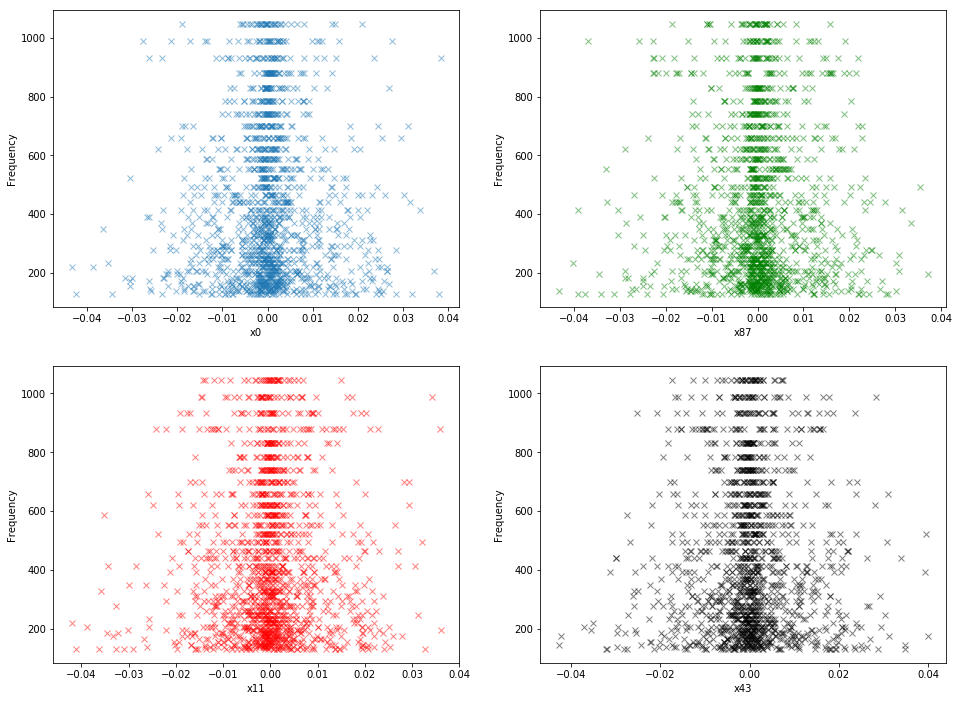

In [15]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
ax[0,0].plot(X_train["x0"], y_train, 'x', alpha=.5)
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('Frequency')
ax[0,1].plot(X_train["x87"], y_train, 'gx', alpha=.5)
ax[0,1].set_xlabel('x87')
ax[0,1].set_ylabel('Frequency')
ax[1,0].plot(X_train["x11"], y_train, 'rx', alpha=.5)
ax[1,0].set_xlabel('x11')
ax[1,0].set_ylabel('Frequency')
ax[1,1].plot(X_train["x43"], y_train, 'kx', alpha=.5)
ax[1,1].set_xlabel('x43')
ax[1,1].set_ylabel('Frequency')

We could try using the standard deviation of the features

## Re-training the model using std as a feature

In [11]:
data["Freq"].unique()

array([ 233.08188076,  466.16376152,  932.32752304,  220.        ,
        440.        ,  880.        ,  246.94165063,  493.88330126,
        987.76660251,  138.59131549,  277.18263098,  554.36526195,
        130.81278265,  261.6255653 ,  523.2511306 , 1046.5022612 ,
        155.56349186,  311.12698372,  622.25396744,  146.83238396,
        293.66476792,  587.32953583,  164.81377846,  329.62755691,
        659.25511383,  184.99721136,  369.99442271,  739.98884542,
        174.61411572,  349.22823143,  698.45646287,  207.65234879,
        415.30469758,  830.60939516,  195.99771799,  391.99543598,
        783.99087196])

In [23]:
k = data.shape[1] - 1
data_std = pd.DataFrame(columns=["x{}".format(i) for i in range(100)].append("Freq"))

for freq in data["Freq"].unique():
    df = pd.DataFrame(data[data["Freq"] == freq].drop("Freq", axis=1).std().values.reshape(1, k), 
                      columns=["x{}".format(i) for i in range(k)])
    df["Freq"] = freq
    data_std = data_std.append(df)
    
data_std = data_std.reset_index().drop("index", axis=1)

In [24]:
data_std.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,Freq
0,0.008268,0.006678,0.009185,0.007864,0.008040,0.010293,0.011769,0.011860,0.009472,0.007092,...,0.007829,0.010020,0.011569,0.010935,0.008476,0.007192,0.008911,0.010607,0.010744,233.081881
1,0.010730,0.010021,0.009204,0.009282,0.009538,0.008948,0.009129,0.008790,0.008883,0.009072,...,0.009245,0.008667,0.008709,0.009652,0.009766,0.010837,0.010778,0.010665,0.010457,466.163762
2,0.011349,0.010468,0.009723,0.009913,0.009685,0.009959,0.010137,0.010472,0.010735,0.010492,...,0.010631,0.010627,0.010079,0.010073,0.010016,0.009867,0.010215,0.011010,0.011384,932.327523
3,0.012717,0.012367,0.010159,0.009468,0.007979,0.008072,0.008018,0.008376,0.009747,0.012769,...,0.013233,0.011290,0.009661,0.009455,0.008997,0.009477,0.009670,0.009500,0.010116,220.000000
4,0.008213,0.009147,0.009317,0.009638,0.010750,0.012532,0.013261,0.012617,0.012145,0.011560,...,0.009199,0.008302,0.010037,0.011467,0.012172,0.012756,0.013257,0.012092,0.009784,440.000000


Now there seems to be some correlation

Text(0,0.5,'Frequency')

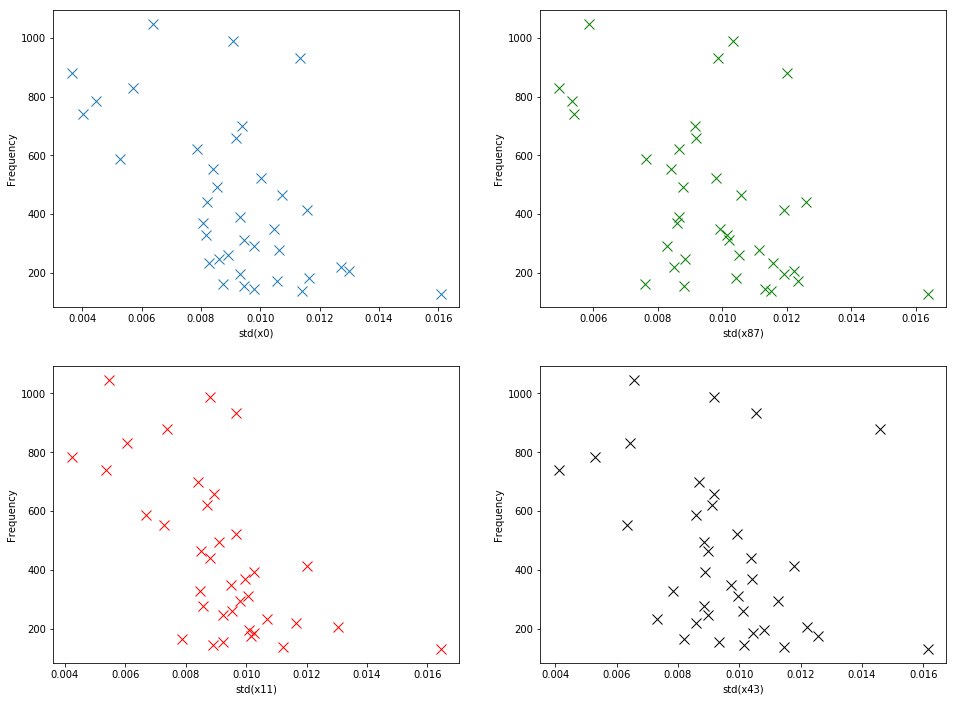

In [25]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
ax[0,0].plot(data_std["x0"], data_std["Freq"], 'x', markersize=10)
ax[0,0].set_xlabel('std(x0)')
ax[0,0].set_ylabel('Frequency')
ax[0,1].plot(data_std["x87"], data_std["Freq"], 'gx', markersize=10)
ax[0,1].set_xlabel('std(x87)')
ax[0,1].set_ylabel('Frequency')
ax[1,0].plot(data_std["x11"], data_std["Freq"], 'rx', markersize=10)
ax[1,0].set_xlabel('std(x11)')
ax[1,0].set_ylabel('Frequency')
ax[1,1].plot(data_std["x43"], data_std["Freq"], 'kx', markersize=10)
ax[1,1].set_xlabel('std(x43)')
ax[1,1].set_ylabel('Frequency')

However, the features are also correlated amongst them

Text(0,0.5,'std(x43)')

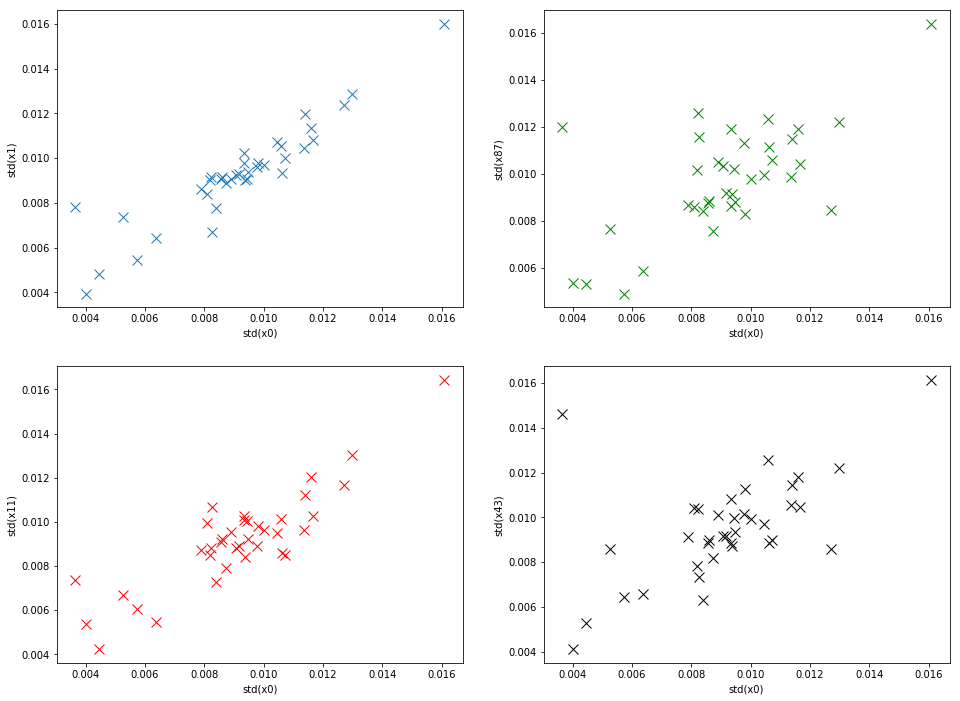

In [26]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
ax[0,0].plot(data_std["x0"], data_std["x1"], 'x', markersize=10)
ax[0,0].set_xlabel('std(x0)')
ax[0,0].set_ylabel('std(x1)')
ax[0,1].plot(data_std["x0"], data_std["x87"], 'gx', markersize=10)
ax[0,1].set_xlabel('std(x0)')
ax[0,1].set_ylabel('std(x87)')
ax[1,0].plot(data_std["x0"], data_std["x11"], 'rx', markersize=10)
ax[1,0].set_xlabel('std(x0)')
ax[1,0].set_ylabel('std(x11)')
ax[1,1].plot(data_std["x0"], data_std["x43"], 'kx', markersize=10)
ax[1,1].set_xlabel('std(x0)')
ax[1,1].set_ylabel('std(x43)')

We'll choose the x that has a higher correlation with frequency

In [27]:
data_std.corr()["Freq"].drop("Freq").abs().idxmax()

'x19'

As with x0, it's highly correlated with the other xs

In [28]:
data_std.corr()["x19"].drop("Freq").abs().min()

0.6528126144003801

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data_std[["x19", "Freq"]], "Freq")

In [32]:
X_train.head()

,x19
24,0.008959
7,0.008864
9,0.010435
21,0.006515
20,0.010037


In [34]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((30, 1), (30,), (4, 1), (4,), (3, 1), (3,))

The score of the model has improved greatly

In [35]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.43011503679933705

Text(0,0.5,'Frequency')

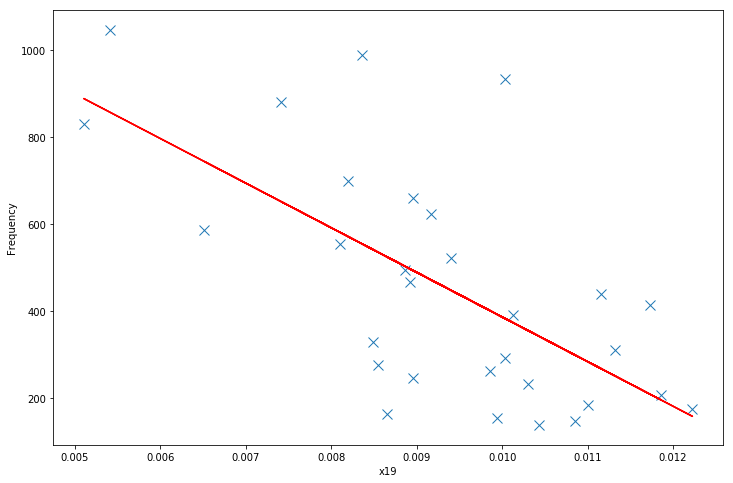

In [52]:
plt.figure(figsize=(12,8))
plt.plot(X_train, y_train, 'x', markersize=10)
plt.plot(X_train, reg.predict(X_train), 'r')
plt.xlabel('x19')
plt.ylabel("Frequency")

However, our accuracy metric is actually whether the predicted note matches the true note

In [83]:
def accuracy(prediction, actual):
    return (np.array(librosa.hz_to_note(prediction)) == np.array(librosa.hz_to_note(actual))).mean()

In [91]:
accuracy(reg.predict(X_train), y_train)

0.03333333333333333

In [90]:
print('{:>8} {:>8}'.format("Predicted","Actual"))
for x,y in zip(np.array(librosa.hz_to_note(reg.predict(X_train))),
               np.array(librosa.hz_to_note(y_train))):
    print('{:>8} {:>8} {:>8}'.format(x,y, x==y))

Predicted   Actual
      B4       E5        0
      B4       B4        1
      F4      C#3        0
     F#5       D5        0
      G4       D4        0
      B4      A#4        0
      G4      A#5        0
      G3      G#3        0
      D5       F5        0
     F#4       G4        0
      B3      D#4        0
      C5      C#4        0
     A#4      D#5        0
      C4       A4        0
      D5      C#5        0
      E5       A5        0
     C#4      F#3        0
     D#3       F3        0
      G4      D#3        0
     C#5       B5        0
     C#5       E4        0
      A4       C5        0
      B4       B3        0
      G4       C4        0
      C5       E3        0
      F4      A#3        0
      D4       D3        0
      A5       C6        0
      A5      G#5        0
     G#3      G#4        0


Clearly linear regression is not an adequate algorithm for this problem.